# ply image Matcher
Matching the POV perspective of the pointcloud with the images provided

Load images and perform some pre-processing. <br>
For now, handpicked similar images from the `ply_pov` directory and `_Images` directory are used to get a base understanding of the calculated similarity between 2 images

In [1]:
import torch
import open_clip
import cv2
from sentence_transformers import util
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import os

ModuleNotFoundError: No module named 'torch'

In [3]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Print CUDA version
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)

Using device: cuda
CUDA version: 12.4


Load images

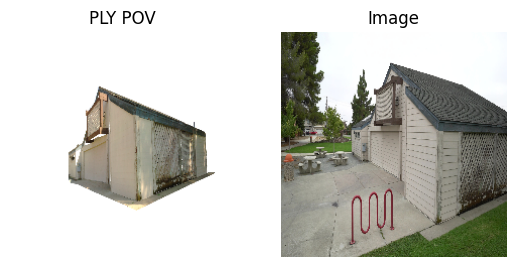

In [4]:
img1 = cv2.imread("../../Dataset/Barn_data/Barn_ply/ply_pov/Barn01.png") # ply_pov
img2 = cv2.imread("../../Dataset/Barn_data/Barn_images/000059.jpg") # image

# Resize the images to 224x224 as required by OpenCLIP
img1 = cv2.resize(img1, (224, 224))
img2 = cv2.resize(img2, (224, 224))

# Display images side by side
fig, ax = plt.subplots(1, 2)
ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[0].axis("off")
ax[0].set_title("PLY POV")

ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1].axis("off")
ax[1].set_title("Image")

plt.show()

## 1. Using SSIM Similarity

In [5]:
# Function to calculate SSIM between two images
def calculate_ssim(image1, image2):
    
    # Ensure images are of the same size for SSIM calculation
    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions")
    
    score, _ = ssim(img1, img2, full=True, win_size=7, channel_axis=-1 if image1.ndim == 3 else None)
    return score

In [6]:
# Calculate SSIM between the two images
ssim_score = calculate_ssim(img1, img2)
print("SSIM score:", ssim_score)

SSIM score: 0.29984857000538656


## 2. Using CLIP

In [7]:
model, _, preprocess = open_clip.create_model_and_transforms(model_name='ViT-B-16-plus-240',
                                                             pretrained="laion400m_e32")
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 896, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=896, out_features=896, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=896, out_features=3584, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3584, out_features=896, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((896,), eps=1e-05, elementwise_affine

In [8]:
# Function to encode image
def image_encoder(img):
    img = Image.fromarray(img).convert('RGB')
    img = preprocess(img).unsqueeze(0).to(device)
    img = model.encode_image(img)
    return img

# Function to calculate cosine similarity between two images
def calcualte_cosine_similarity(img1, img2):
    # Encode the images
    img1 = image_encoder(img1)
    img2 = image_encoder(img2)

    # Calculate cosine similarity
    cos_sim = util.pytorch_cos_sim(img1, img2)

    return cos_sim.item()

In [9]:
# Calculate cosine similarity between the two images
cos_sim_score = calcualte_cosine_similarity(img1, img2)
print("Cosine similarity score:", cos_sim_score)

Cosine similarity score: 0.38708168268203735


In [50]:
img1 = cv2.imread("../../Dataset/Barn_data/Barn_ply/ply_pov/Barn01.png") # ply_pov
img2 = cv2.imread("../../Dataset/Barn_data/Barn_images/000059.jpg") # image


# Resize the images to 224x224 as required by OpenCLIP
img1 = cv2.resize(img1, (224, 224))
img2 = cv2.resize(img2, (224, 224))

def preprocess_image(image):
    
    # Convert image to Grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Slightly blur the image
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply adaptive thresholding
    # image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    return image

# Preprocess the images
img1 = preprocess_image(img1)
img2 = preprocess_image(img2)

# Calculate cosine similarity and SSIM between the two images
cos_sim_score = calcualte_cosine_similarity(img1, img2)
ssim_score = calculate_ssim(img1, img2)

print("Cosine similarity score:", cos_sim_score)
print("SSIM score:", ssim_score)


Cosine similarity score: 0.4924499988555908
SSIM score: 0.4123496287238235


In [55]:
# Calcluate the SSIM and cosine similarity between img1 and every image in the dataset
# And plot a graph of the scores
dataset_path = "/home/apoorv/Documents/CMSC848K/ObitoNet/Dataset/Barn_data/Barn_images"

# Get all the image filenames in the dataset
image_filenames = sorted(os.listdir(dataset_path), key=lambda x: int(x.split(".")[0]))

# Read the images
images = [cv2.imread(f"{dataset_path}/{img}") for img in image_filenames]


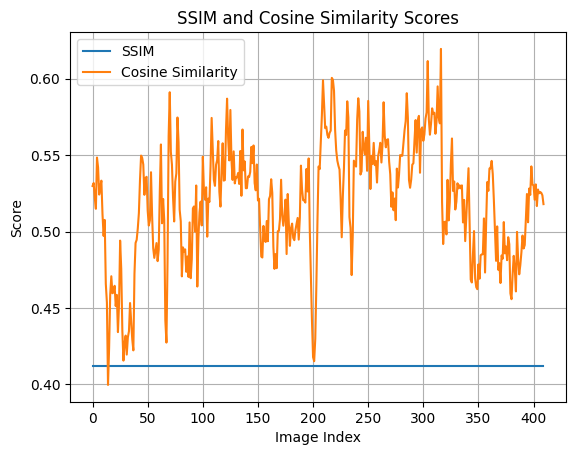

In [59]:
ssim_scores = []
cos_sim_scores = []

for image in images:
    image = cv2.resize(image, (224, 224))
    image = preprocess_image(image)
    
    cos_sim_score = calcualte_cosine_similarity(img1, image)
    ssim_score = calculate_ssim(img1, image)
    
    ssim_scores.append(ssim_score)
    cos_sim_scores.append(cos_sim_score)

# Plot the scores
plt.figure()
plt.plot(ssim_scores, label="SSIM")
plt.plot(cos_sim_scores, label="Cosine Similarity")
plt.xlabel("Image Index")
plt.ylabel("Score")
plt.title("SSIM and Cosine Similarity Scores")
plt.legend()
plt.grid()
plt.show()

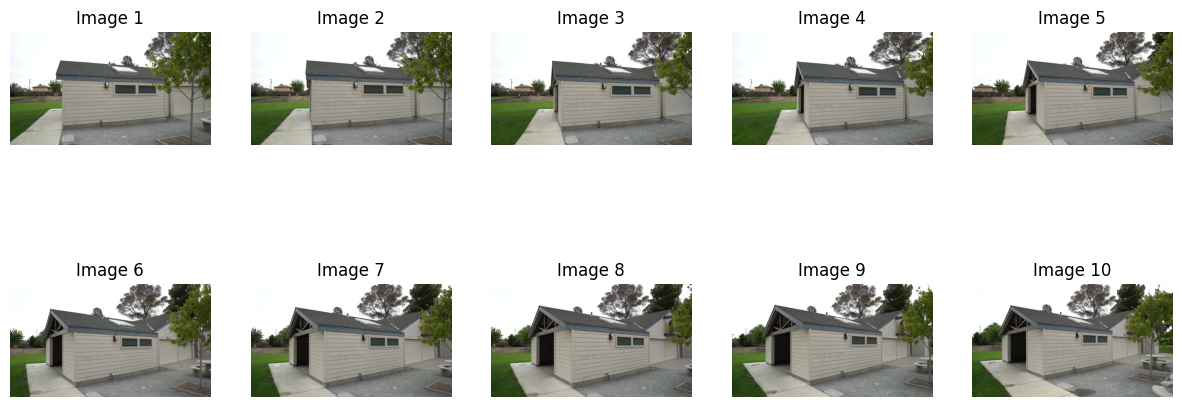

In [56]:
# Show the first 10 images in the dataset
fig, ax = plt.subplots(2, 5, figsize=(15, 6))

for i in range(10):
    ax[i//5, i%5].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax[i//5, i%5].axis("off")
    ax[i//5, i%5].set_title(f"Image {i+1}")

plt.show()

## 3. Histogram Based Matching

In [15]:
# Calculate histogram of first image
hist_img1 = cv2.calcHist([img1], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
hist_img1[255, 255, 255] = 0 #ignore all white pixels
cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# Calculate histogram of second image
hist_img2 = cv2.calcHist([img2], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
hist_img2[255, 255, 255] = 0  #ignore all white pixels
cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# Find the metric value
metric_val = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_CORREL)
print(f"Similarity Score: ", round(metric_val, 2))

Similarity Score:  0.0


## 4. Template Matching

In [16]:
img1 = cv2.imread("../../Dataset/Barn_data/Barn_ply/ply_pov/Barn01.png") # ply_pov
img2 = cv2.imread("../../Dataset/Barn_data/Barn_images/000059.jpg") # image

# Resize the images to 224x224 as required by OpenCLIP
img1 = cv2.resize(img1, (224, 224))
img2 = cv2.resize(img2, (224, 224))

In [17]:
# Convert images to grayscale for template matching
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Perform template matching
result = cv2.matchTemplate(img2_gray, img1_gray, cv2.TM_CCOEFF_NORMED)

# Find the maximum similarity value
_, max_val, _, _ = cv2.minMaxLoc(result)

# Print the similarity score
print(f"Similarity Score: {max_val}")


Similarity Score: 0.034740298986434937


## 5. Feature Matching

In [26]:
import cv2

# Load the images
img1 = cv2.imread("../../Dataset/Barn_data/Barn_ply/ply_pov/Barn01.png")  # ply_pov
img2 = cv2.imread("../../Dataset/Barn_data/Barn_images/000059.jpg")      # image

# Resize the images to a fixed size for consistency
resize_dim = (540, 540)
img1 = cv2.resize(img1, resize_dim)
img2 = cv2.resize(img2, resize_dim)

# Convert images to grayscale for feature extraction
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# Check if descriptors are valid
if descriptors1 is None or descriptors2 is None:
    print("No descriptors found in one or both images.")
    similarity_percentage = 0.0
else:
    # Initialize a brute-force matcher
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    # Match descriptors with KNN (find the two best matches for each descriptor)
    knn_matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply Lowe's ratio test to filter matches
    good_matches = []
    for m, n in knn_matches:
        if m.distance < 0.9 * n.distance:  # Lowe's ratio test threshold
            good_matches.append(m)

    # Calculate the similarity percentage
    if len(keypoints1) > 0:  # Ensure img1 has detected features
        similarity_percentage = (len(good_matches) / len(keypoints1)) * 100
    else:
        similarity_percentage = 0.0

    # Output the similarity score
    print(f"Number of features in img1: {len(keypoints1)}")
    print(f"Number of features matched in img2 (after Lowe's test): {len(good_matches)}")
    print(f"Similarity Percentage: {similarity_percentage:.2f}%")

    # Visualize the matches (only show the top 50 matches for clarity)
    matched_image = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    cv2.imshow("Feature Matches (After Lowe's Test)", matched_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


Number of features in img1: 345
Number of features matched in img2 (after Lowe's test): 80
Similarity Percentage: 23.19%
